инициализация библиотек

In [1]:
import torch
from torch import nn
import torch.optim as optim
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

перевод датасета в torch.Tensor и его преобразование

In [24]:
def get_dataset(X, y, img_transforms):
    tensor_x = torch.Tensor(X)
    tensor_x = img_transforms(tensor_x)
    tensor_y = torch.Tensor(y).long()

    dataset = TensorDataset(tensor_x,tensor_y)
    return dataset

Функция обучения нейронки

In [25]:
def train(net: torch.nn.Sequential, train_loader, device, num_epochs, learning_rate):
    
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    loss_function = torch.nn.CrossEntropyLoss()
    acc_history = []
    net.to(device)

    with tqdm(total=len(train_loader)*num_epochs, position=0, leave=True) as pbar:

        for epoch in range(num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0 
            
            for batch_num, (inputs, labels) in enumerate(train_loader):
                # Possibly copy inputs and labels to the GPU
                # batch x [48, 48, 1] -> batch x [1, 48, 48]
                inputs = inputs.permute(0, 3, 1, 2).to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                # Forward pass
                outputs = net(inputs)
                loss = loss_function(outputs, labels)

                # Backpropagation                
                loss.backward()

                # Update
                optimizer.step()

                # Print progress
                running_loss += loss.item()

                # Calculate batch Accuracy
                _, predicted = outputs.max(1)
                batch_total = labels.size(0)
                batch_correct = predicted.eq(labels).sum().item()
                batch_acc = batch_correct/batch_total
                
                pbar.set_description("Epoch: %d, Batch: %2d, Loss: %.2f, Acc: %.2f" % (epoch, batch_num, running_loss, batch_acc))
                pbar.update()

                total += batch_total
                correct += batch_correct

            # Print the evaluation metric and reset it for the next epoch
            acc = correct/total 
            acc_history.append(acc)

        pbar.close()

    return acc_history


Функция для inference и расчета accurancy 

In [26]:
def evaluate_acc(net, test_loader, device):

    total = 0
    correct = 0
    
    for batch_num, (inputs, labels) in enumerate(test_loader):
        # Possibly copy inputs and labels to the GPU
        inputs = inputs.permute(0, 3, 1, 2).to(device)
        labels = labels.to(device)
        
        outputs = net(inputs)        
        _, predicted = outputs.max(1)
        
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    acc = correct/total
    return acc

In [27]:
def print_history(history, title):
    plt.figure(figsize=(7, 4))
    plt.plot(history)
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [29]:
train_fh = open('/home/victor/Datasets/Data-Science/lego/lego-train.pickle', 'rb')
test_fh = open('/home/victor/Datasets/Data-Science/lego/lego-test.pickle', 'rb')

train_data = pickle.load(train_fh)
test_data = pickle.load(test_fh)

Получение тестового и тренировочного датасета

In [30]:
train_data_X = [img for (img, _) in train_data]
train_data_y = [lbl for (_, lbl) in train_data]

test_data_X = [img for (img, _) in test_data]
test_data_y = [lbl for (_, lbl) in test_data]

img_transforms = transforms.Compose([
    transforms.Normalize(0.13, 0.31)])

train_dataset = get_dataset(train_data_X, train_data_y, img_transforms)
test_dataset = get_dataset(test_data_X, test_data_y, img_transforms)

train_dataset

Инициализация сети с 6 слоями

In [31]:
def buildCNN():
    net = torch.nn.Sequential(
    # Input: 48x48
    
        nn.Conv2d(1, 6, 5, padding=(2,2)), # out: 48x48x6
        nn.ReLU(),
    
        nn.AvgPool2d(kernel_size=(2,2), stride=(2,2)), # out: 24x24x6
        nn.ReLU(),
    
        nn.Conv2d(6, 16, 5), # out: 20x20x16
        nn.ReLU(),
    
        nn.AvgPool2d(kernel_size=(2,2), stride=(2,2)), # out: 10x10x16
        nn.ReLU(),
    
        nn.Conv2d(16, 32, 3, padding=1), # out: 10x10x32
        nn.ReLU(),
    
        nn.AvgPool2d(kernel_size=(2,2), stride=(2,2)), # out: 5x5x32
        nn.ReLU(),
    
        nn.Conv2d(32, 64, 3, padding=1), # out: 5x5x64
        nn.ReLU(),
    
        nn.AvgPool2d(kernel_size=(2,2), stride=(2,2)), # out: 2x2x64

        nn.Flatten(),
    
        nn.Linear(2*2*64, 120),
        nn.Tanh(),
        
        nn.Linear(120, 80),
        nn.Sigmoid(),
        
        nn.Linear(80, 10)
    )
    return net

Обоваричаем датасет в DataLoader для обучения модели и инициализируем переменных: размер батча, количеств оэпох и шаг градиентного спуска

In [32]:
BATCH_SIZE = 32
EPOCHS = 200
LR = 0.001
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

Инициализация CNN и ее обучение

In [33]:
net = buildCNN()
hist = train(net, train_loader, device, EPOCHS, LR)

Epoch: 0, Batch:  0, Loss: 2.38, Acc: 0.12:   0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 199, Batch: 14, Loss: 1.92, Acc: 1.00: 100%|██████████| 3000/3000 [00:09<00:00, 311.08it/s]


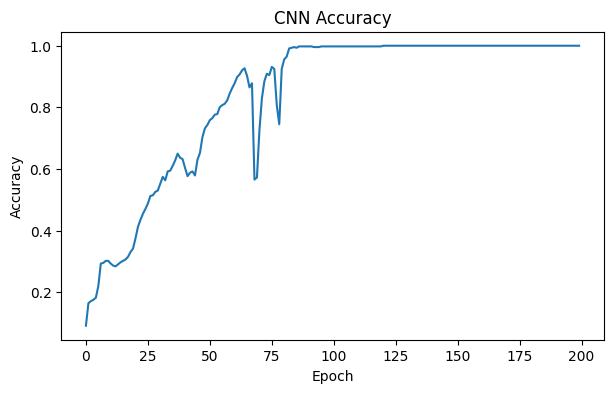

In [34]:
print_history(hist, "CNN Accuracy")

**Вывод:** можно было остановиться примерно на 150 эпохах

In [ ]:
train_accurancy = evaluate_acc(net, train_loader, device)
test_accurancy = evaluate_acc(net, test_loader, device)
print(
    f"Train accurancy: {round(train_accurancy, 8)}",
    f"Test accurancy: {round(test_accurancy, 8)}"
)

Train accurancy: 1.0 Test accurancy: 1.0
